In [1]:
import pathlib # manipulate paths
import glob 
# import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from pandas import Series,DataFrame
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Now upload the file 
from google.colab import files
files.upload()

Saving Wish_overview - Sheet5.csv to Wish_overview - Sheet5.csv


{'Wish_overview - Sheet5.csv': b'prod_gen,discount_price,retail_price,discount_price_in_original_currency,nb_cart_orders_approx,rating,rating_count,product_color,product_variation_size_id,product_variation_inventory,shipping_option_price,shipping_is_express,inventory_total,origin_country,merchant_positive_percent,merchant_rating_count,merchant_rating,isnan\r\nWoman,3.11,4,3.77,5000,4.020408163,539,white,others,50,1,FALSE,50,CN,94,74181,4.476591041,0\r\nWoman,42,42,50,0,-1,0,red,others,2,17,FALSE,2,KR,67,6,3.833333333,1\r\nMan,4.79,44,5.81,1000,3.571428571,42,dual,extra_small_size,1,1,FALSE,50,US,,157,4.006369427,0\r\nWoman,5,5,6,10000,3.906273063,1355,grey,s,50,2,FALSE,50,CN,,15616,4.063140369,0\r\nWoman,4.69,5,5.68,1000,3.505494505,273,yellow,xs,3,1,FALSE,50,CN,85,2034,4.002949853,0\r\nMan,3.12,4,3.78,5000,3.941251596,783,white,xs,1,1,FALSE,50,CN,,20219,4.057520154,0\r\nMan,22,29,26.41,0,-1,0,others,others,50,8.99,FALSE,50,VN,90,303,4.320132013,1\r\nWoman,4.13,5,5,20000,3.545133992,28

In [3]:
# Load Dataset
dt = pd.read_csv("/content/Wish_overview - Sheet5.csv")

# Preprocessing

In [5]:
dt.head()

,prod_gen,discount_price,retail_price,discount_price_in_original_currency,nb_cart_orders_approx,rating,rating_count,product_color,product_variation_size_id,product_variation_inventory,shipping_option_price,shipping_is_express,inventory_total,origin_country,merchant_positive_percent,merchant_rating_count,merchant_rating,isnan
0,Woman,3.11,4,3.77,5000,4.020408,539,white,others,50,1.0,False,50,CN,94.0,74181,4.476591,0
1,Woman,42.00,42,50.00,0,-1.000000,0,red,others,2,17.0,False,2,KR,67.0,6,3.833333,1
2,Man,4.79,44,5.81,1000,3.571429,42,dual,extra_small_size,1,1.0,False,50,US,NaN,157,4.006369,0
3,Woman,5.00,5,6.00,10000,3.906273,1355,grey,s,50,2.0,False,50,CN,NaN,15616,4.063140,0
4,Woman,4.69,5,5.68,1000,3.505495,273,yellow,xs,3,1.0,False,50,CN,85.0,2034,4.002950,0


In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   title                                900 non-null    object 
 1   prod_gen                             900 non-null    object 
 2   title_orig                           900 non-null    object 
 3   discount_price                       900 non-null    float64
 4   retail_price                         900 non-null    int64  
 5   discount_price_in_original_currency  900 non-null    float64
 6   nb_cart_orders_approx                900 non-null    int64  
 7   rating                               900 non-null    float64
 8   rating_count                         900 non-null    int64  
 9   product_color                        900 non-null    object 
 10  product_variation_size_id            900 non-null    object 
 11  product_variation_inventory     

In [ ]:
dt.columns

Index(['title', 'prod_gen', 'title_orig', 'discount_price', 'retail_price',
       'discount_price_in_original_currency', 'nb_cart_orders_approx',
       'rating', 'rating_count', 'product_color', 'product_variation_size_id',
       'product_variation_inventory', 'shipping_option_name',
       'shipping_option_price', 'shipping_is_express', 'inventory_total',
       'origin_country', 'merchant_title', 'merchant_name',
       'merchant_positive_percent', 'merchant_rating_count', 'merchant_rating',
       'merchant_id', 'product_url', 'product_picture', 'product_id'],
      dtype='object')

In [ ]:
dt = dt.drop(columns = ['product_url','product_picture','product_id','merchant_id','shipping_option_name','title','title_orig','merchant_title','merchant_name'])

In [ ]:
def fake_rating(dt):
  if (dt['rating_count'] == 0) & (dt['rating']==5):
    return -1
  else: return dt['rating']

In [ ]:
dt['rating'] = dt.apply(fake_rating,axis=1)

In [ ]:
dt[(dt['rating_count'] == 0) & (dt['rating']==5)][['rating']]

,rating


In [ ]:
dt['isnan'] = 0

In [ ]:
def fake_rating(dt):
  if (dt['rating']==-1):
    return 1
  else: return dt['isnan']

In [ ]:
dt['isnan'] = dt.apply(fake_rating,axis=1)

In [ ]:
dt['isnan'].unique()

array([0, 1])

# Train model

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [7]:
stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
kfold = KFold(n_splits=5,shuffle=True, random_state=42)

In [8]:
X = dt.drop(['discount_price','discount_price_in_original_currency'], axis = 1)
y = dt['discount_price']

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# model_r = RandomForestRegressor(n_estimators=10,max_depth=3,n_jobs=2,random_state=2)
# model_r.fit(X_train_transformed,y_train)
# # Instead, just use mean squared error, then manually take the square root of that to have RMSE

# Preprocessing with ordinal Pipeline

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Define numerical columns
numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")
# Define categorical columns
categorical = [col for col in X_train.columns if col not in numerical]
print(f"Categorical columns are: {categorical}")

# Define categorical pipeline
cat_pipe = Pipeline([('encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))])

# Define numerical pipeline
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                     ('scaler', StandardScaler())])


# Fit column transformer to training data
tfm = ColumnTransformer(transformers=[
                                      ('num', num_pipe, numerical),
                                      ('cat', cat_pipe, categorical)],
                        remainder='passthrough'
                        )

X_train_transformed = tfm.fit_transform(X_train)
X_test_transformed = tfm.transform(X_test)

Numerical columns are: ['retail_price', 'nb_cart_orders_approx', 'rating', 'rating_count', 'product_variation_inventory', 'shipping_option_price', 'inventory_total', 'merchant_positive_percent', 'merchant_rating_count', 'merchant_rating', 'isnan']
Categorical columns are: ['prod_gen', 'product_color', 'product_variation_size_id', 'shipping_is_express', 'origin_country']


In [11]:
# Prepare column names
# Prepare column names
# Prepare column names
# cat_columns = tfm.cat__encoder.named_transformers_['cat'].named_steps['encoder']
# columns = np.append(cat_columns, numerical)

# Inspect training data before and after
print("******************** Training data ********************")
display(X_train)
display(pd.DataFrame(X_train_transformed,columns=X_train.columns))

# Inspect test data before and after
print("******************** Test data ********************")
display(X_test)
display(pd.DataFrame(X_test_transformed,columns=X_train.columns))

******************** Training data ********************


,prod_gen,retail_price,nb_cart_orders_approx,rating,rating_count,product_color,product_variation_size_id,product_variation_inventory,shipping_option_price,shipping_is_express,inventory_total,origin_country,merchant_positive_percent,merchant_rating_count,merchant_rating,isnan
613,Woman,20,0,-1.000000,0,black,m,50,6.0,False,50,CA,NaN,1166,3.938250,1
528,Woman,4,10,3.818182,11,pink,xs,50,1.0,False,50,CN,91.0,19295,4.254211,0
815,Woman,9,1000,3.903766,239,white,s,50,3.0,False,50,CN,88.0,9180,4.133333,0
380,Woman,5,1000,4.182609,115,orange,xs,2,2.0,False,50,CN,NaN,321,4.084112,0
300,Woman,73,10,3.727273,33,blue,extra_small_size,1,1.0,False,50,CN,NaN,5343,3.658432,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,Woman,4,5000,4.284983,586,others,others,50,1.0,False,50,CN,93.0,28015,4.388399,0
270,Woman,6,10,4.130435,23,black,others,50,2.0,False,50,CN,NaN,22516,4.161752,0
860,Woman,43,10,4.600000,5,purple,s,50,3.0,False,50,CN,85.0,743,4.006729,0
435,Woman,25,0,-1.000000,0,white,others,14,8.0,True,14,PL,95.0,8961,4.504296,1


,prod_gen,retail_price,nb_cart_orders_approx,rating,rating_count,product_color,product_variation_size_id,product_variation_inventory,shipping_option_price,shipping_is_express,inventory_total,origin_country,merchant_positive_percent,merchant_rating_count,merchant_rating,isnan
0,0.053907,-0.321320,-1.733972,-0.318738,0.808990,0.538011,0.240370,0.000000,-0.366092,-0.400243,1.772316,1.0,1.0,3.0,0.0,0.0
1,-0.675662,-0.320114,0.515805,-0.312023,0.808990,-0.865963,0.240370,0.549901,0.017782,0.477095,-0.564233,1.0,9.0,7.0,0.0,1.0
2,-0.447672,-0.200785,0.555767,-0.172847,0.808990,-0.304373,0.240370,0.353929,-0.196399,0.141450,-0.564233,1.0,12.0,5.0,0.0,1.0
3,-0.630064,-0.200785,0.685969,-0.248539,-1.408734,-0.585168,0.240370,0.000000,-0.383985,0.004776,-0.564233,1.0,7.0,7.0,0.0,1.0
4,2.470605,-0.320114,0.473357,-0.298594,-1.454937,-0.865963,0.240370,0.000000,-0.277646,-1.177225,-0.564233,1.0,2.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,-0.675662,0.281353,0.733771,0.038970,0.808990,-0.865963,0.240370,0.680549,0.202425,0.849699,-0.564233,1.0,8.0,4.0,0.0,1.0
671,-0.584466,-0.320114,0.661607,-0.304698,0.808990,-0.585168,0.240370,0.000000,0.085986,0.220360,-0.564233,1.0,1.0,4.0,0.0,1.0
672,1.102663,-0.320114,0.880863,-0.315686,0.808990,-0.304373,0.240370,0.157957,-0.375049,-0.210095,-0.564233,1.0,10.0,5.0,0.0,1.0
673,0.281897,-0.321320,-1.733972,-0.318738,-0.854303,1.099601,-3.872999,0.811197,-0.201036,1.171515,1.772316,1.0,12.0,4.0,1.0,6.0


******************** Test data ********************


,prod_gen,retail_price,nb_cart_orders_approx,rating,rating_count,product_color,product_variation_size_id,product_variation_inventory,shipping_option_price,shipping_is_express,inventory_total,origin_country,merchant_positive_percent,merchant_rating_count,merchant_rating,isnan
70,Woman,13,10,4.027027,37,black,s,50,4.0,False,50,CN,88.0,4195,4.144458,0
827,Woman,10,5000,4.132943,1196,white,s,50,3.0,False,50,CN,83.0,15939,3.927536,0
231,Woman,10,10,3.645669,127,red,extra_big_size,42,2.0,False,50,CN,87.0,46351,4.067658,0
588,Woman,11,10,2.692308,26,white,s,50,3.0,False,50,CN,85.0,7622,4.018893,0
39,Woman,10,10000,4.258103,833,brown,s,50,3.0,False,50,CN,89.0,94291,4.199139,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,Man,46,1000,3.882353,306,white,s,25,2.0,False,50,CN,NaN,404,4.071782,0
351,Woman,23,10,-1.000000,0,white,s,50,7.0,False,50,CA,80.0,1166,3.938250,1
429,Woman,29,0,-1.000000,0,blue,s,50,9.0,False,50,CA,80.0,1166,3.938250,1
101,Woman,4,20000,3.907472,2021,dual,s,3,1.0,False,50,CN,NaN,63028,4.115520,0


,prod_gen,retail_price,nb_cart_orders_approx,rating,rating_count,product_color,product_variation_size_id,product_variation_inventory,shipping_option_price,shipping_is_express,inventory_total,origin_country,merchant_positive_percent,merchant_rating_count,merchant_rating,isnan
0,-0.265279,-0.320114,0.613322,-0.296152,0.808990,-0.023578,0.24037,0.353929,-0.301954,0.172339,-0.564233,1.0,1.0,5.0,0.0,1.0
1,-0.402074,0.281353,0.662778,0.411329,0.808990,-0.304373,0.24037,0.027309,-0.053280,-0.429994,-0.564233,1.0,12.0,5.0,0.0,1.0
2,-0.402074,-0.320114,0.435253,-0.241214,0.439370,-0.585168,0.24037,0.288605,0.590682,-0.040914,-0.564233,1.0,11.0,0.0,0.0,1.0
3,-0.356476,-0.320114,-0.009905,-0.302867,0.808990,-0.304373,0.24037,0.157957,-0.229389,-0.176321,-0.564233,1.0,12.0,5.0,0.0,1.0
4,-0.402074,0.884026,0.721220,0.189745,0.808990,-0.304373,0.24037,0.419253,1.605793,0.324174,-0.564233,1.0,3.0,5.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,1.239457,-0.200785,0.545769,-0.131948,-0.346075,-0.585168,0.24037,0.000000,-0.382227,-0.029461,-0.564233,0.0,12.0,5.0,0.0,1.0
221,0.190701,-0.320114,-1.733972,-0.318738,0.808990,0.818806,0.24037,-0.168664,-0.366092,-0.400243,1.772316,1.0,12.0,5.0,0.0,0.0
222,0.464290,-0.321320,-1.733972,-0.318738,0.808990,1.380396,0.24037,-0.168664,-0.366092,-0.400243,1.772316,1.0,2.0,5.0,0.0,0.0
223,-0.675662,2.089371,0.557498,0.914928,-1.362532,-0.865963,0.24037,0.000000,0.943811,0.091987,-0.564233,1.0,4.0,5.0,0.0,1.0


# Training model

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor

In [14]:
# YOUR CODE HERE

rmse_val = {}

# run DecisionTreeRegressor using cross_val_score
scores = cross_val_score(DecisionTreeRegressor(),
                         X_train_transformed, y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

tree_rmse_score = np.sqrt(-scores)
tree_score = np.mean(tree_rmse_score)
print(f"The RMSE for Decision Tree Regressor (with CV=5) is {tree_score:.2f}")

rmse_val['Decision Tree'] = tree_score

The RMSE for Decision Tree Regressor (with CV=5) is 5.04


In [15]:
# run Linear Regressor using cross_val_score
scores = cross_val_score(LinearRegression(),
                         X_train_transformed, y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

lnr_rmse_score = np.sqrt(-scores)
lnr_score = np.mean(lnr_rmse_score)
print(f"The RMSE for Linear Regressor (with CV=5) is {lnr_score:.2f}")

rmse_val['Linear Regression'] = lnr_score

The RMSE for Linear Regressor (with CV=5) is 8.25


In [16]:
# Lasso, Ridge & Elastic Regression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [17]:
scores = cross_val_score(Ridge(),
                         X_train_transformed, y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

ridge_rmse_score = np.sqrt(-scores)
ridge_score = np.mean(ridge_rmse_score)
print(f"The RMSE for Ridge Regression (with CV=5) is {ridge_score:.2f}")

rmse_val['Rigde Regression'] = ridge_score

The RMSE for Ridge Regression (with CV=5) is 8.24


In [18]:
scores = cross_val_score(Lasso(),
                         X_train_transformed, y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

lasso_rmse_score = np.sqrt(-scores)
lasso_score = np.mean(lasso_rmse_score)
print(f"The RMSE for Lasso Regression (with CV=5) is {lasso_score:.2f}")

rmse_val['Lasso Regression'] = lasso_score

The RMSE for Lasso Regression (with CV=5) is 7.69


In [19]:
scores = cross_val_score(ElasticNet(),
                         X_train_transformed, y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

elastic_rmse_score = np.sqrt(-scores)
elastic_score = np.mean(elastic_rmse_score)
print(f"The RMSE for ElasticNet (with CV=5) is {elastic_score:.2f}")

rmse_val['ElasticNet'] = elastic_score

The RMSE for ElasticNet (with CV=5) is 7.78


In [20]:
rmse_val

{'Decision Tree': 5.035147102626523,
 'ElasticNet': 7.780919679303506,
 'Lasso Regression': 7.688378350779618,
 'Linear Regression': 8.249007647540802,
 'Rigde Regression': 8.24307333058073}

In [21]:
# SVM, kNN
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNR

In [22]:
scores = cross_val_score(SVR(),
                         X_train_transformed, y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

svr_rmse_score = np.sqrt(-scores)
svr_score = np.mean(svr_rmse_score)
print(f"The RMSE for SVM (with CV=5) is {svr_score:.2f}")

rmse_val['SVM'] = svr_score

The RMSE for SVM (with CV=5) is 8.64


In [23]:
scores = cross_val_score(KNR(),
                         X_train_transformed, y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

knn_rmse_score = np.sqrt(-scores)
knn_score = np.mean(knn_rmse_score)
print(f"The RMSE for kNN (with CV=5) is {knn_score:.2f}")

rmse_val['kNN'] = knn_score

The RMSE for kNN (with CV=5) is 7.79


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

In [25]:
# Random Forest Regressor
scores = cross_val_score(RandomForestRegressor(),
                         X_train_transformed, y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

rfr_rmse_score = np.sqrt(-scores)
rfr_score = np.mean(rfr_rmse_score)
print(f"The RMSE for Random Forest (with CV=5) is {rfr_score:.2f}")

rmse_val['Random Forest'] = rfr_score

The RMSE for Random Forest (with CV=5) is 5.58


In [26]:
# Gradient Boost Regressor
scores = cross_val_score(GradientBoostingRegressor(),
                         X_train_transformed, y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

gb_rmse_score = np.sqrt(-scores)
gb_score = np.mean(gb_rmse_score)
print(f"The RMSE for Gradient Boost Regressor (with CV=5) is {gb_score:.2f}")

rmse_val['Gradient Boost Regressor'] = gb_score

The RMSE for Gradient Boost Regressor (with CV=5) is 4.53


In [27]:
# AdaBoost Regressor
scores = cross_val_score(AdaBoostRegressor(),
                         X_train_transformed, y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

ada_rmse_score = np.sqrt(-scores)
ada_score = np.mean(ada_rmse_score)
print(f"The RMSE for AdaBoost (with CV=5) is {ada_score:.2f}")

rmse_val['AdaBoost'] = ada_score

The RMSE for AdaBoost (with CV=5) is 5.56


In [28]:
from xgboost import XGBRegressor

In [29]:
!pip install lightgbm==3.3.1

ERROR: Operation cancelled by user


In [30]:
import lightgbm as lgb

In [31]:
# XGBoost Regressor
scores = cross_val_score(XGBRegressor(),
                         X_train_transformed, y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

xgb_rmse_score = np.sqrt(-scores)
xgb_score = np.mean(xgb_rmse_score)
print(f"The RMSE for XGBoost (with CV=5) is {xgb_score:.2f}")

rmse_val['XGBoost'] = xgb_score

[02:06:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:06:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:06:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:06:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:06:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The RMSE for XGBoost (with CV=5) is 6.48


In [32]:
# LightGBM Regressor
scores = cross_val_score(lgb.LGBMRegressor(),
                         X_train_transformed, y_train,
                         scoring="neg_mean_squared_error",
                         cv=5)

lightgbm_rmse_score = np.sqrt(-scores)
lightgbm_score = np.mean(lightgbm_rmse_score)
print(f"The RMSE for LightGBM (with CV=5) is {lightgbm_score:.2f}")

rmse_val['LightGBM'] = lightgbm_score

The RMSE for LightGBM (with CV=5) is 4.86


In [33]:
rmse_val

{'AdaBoost': 5.561035069745131,
 'Decision Tree': 5.035147102626523,
 'ElasticNet': 7.780919679303506,
 'Gradient Boost Regressor': 4.52561668291819,
 'Lasso Regression': 7.688378350779618,
 'LightGBM': 4.858095103843615,
 'Linear Regression': 8.249007647540802,
 'Random Forest': 5.584898053967507,
 'Rigde Regression': 8.24307333058073,
 'SVM': 8.642017980158936,
 'XGBoost': 6.476692205430249,
 'kNN': 7.788186548443029}

In [34]:
rmse_df = pd.DataFrame.from_dict(rmse_val, orient='index').reset_index()
rmse_df.columns = ["Algorithm","RMSE"]
rmse_df = rmse_df.sort_values("RMSE", ascending=False).reset_index(drop=True)
rmse_df

,Algorithm,RMSE
0,SVM,8.642018
1,Linear Regression,8.249008
2,Rigde Regression,8.243073
3,kNN,7.788187
4,ElasticNet,7.780920
5,Lasso Regression,7.688378
6,XGBoost,6.476692
7,Random Forest,5.584898
8,AdaBoost,5.561035
9,Decision Tree,5.035147


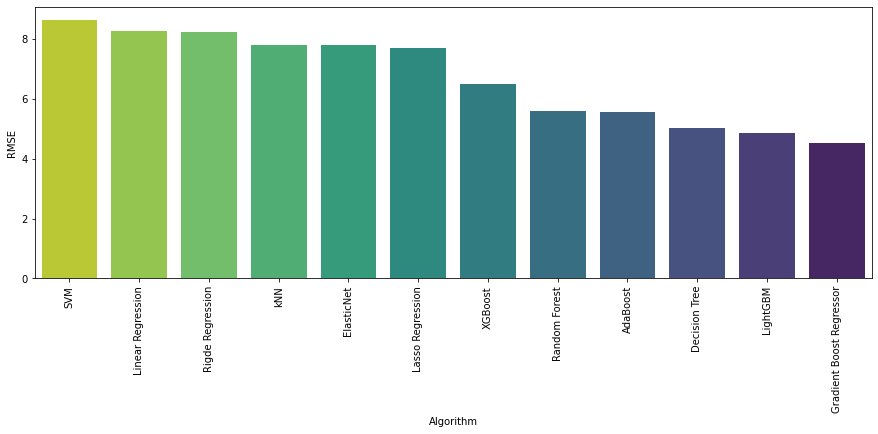

In [35]:
plt.figure(figsize=(15,5))
sns.barplot(data = rmse_df, x="Algorithm", y = "RMSE", palette="viridis_r")
plt.xticks(rotation=90)
plt.show()

# Model Tunning

## With default

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_r = RandomForestRegressor(n_estimators=10,max_depth=3,n_jobs=2,random_state=2)
model_r.fit(X_train_transformed,y_train)
# Instead, just use mean squared error, then manually take the square root of that to have RMSE

RandomForestRegressor(max_depth=3, n_estimators=10, n_jobs=2, random_state=2)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

success_pred_forest = model_r.predict(X_test_transformed)
forest_mse = MSE(success_pred_forest,y_test)
forest_rmse = np.sqrt(forest_mse)
forest_mae = MAE(success_pred_forest,y_test)


print(f"The RMSE for Random forest regression model is {forest_mse:.2f}")
print(f"The MAE for Random forest regression model is {forest_mae:.2f}")

# Hint: there is no 'root_mean_squared_error' in sklearn. 

The RMSE for Random forest regression model is 23.87
The MAE for Random forest regression model is 2.78


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

model_x = XGBRegressor(n_estimators=100,max_depth=3)
model_x.fit(X_train_transformed,y_train)


success_pred_xgboost = model_x.predict(X_test_transformed)
xgboost_mse = MSE(success_pred_xgboost,y_test)
xgboost_rmse = np.sqrt(xgboost_mse)
xgboost_mae = MAE(success_pred_forest,y_test)

print(f"The RMSE for Random xgboost regression model is {xgboost_mse:.2f}")
print(f"The MAE for Random xgboost regression model is {forest_mae:.2f}")

[15:13:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The RMSE for Random xgboost regression model is 26.82
The MAE for Random xgboost regression model is 2.78


<BarContainer object of 15 artists>

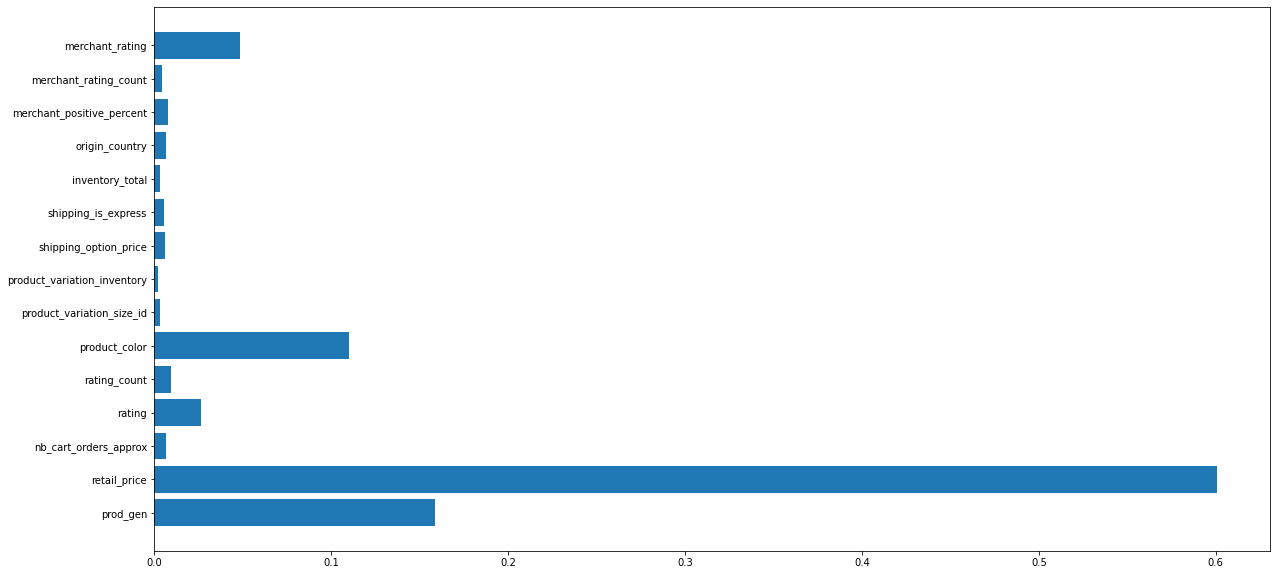

In [ ]:
plt.figure(figsize= (20,10))
plt.barh(X_train.columns,model_x.feature_importances_)

## Tunning model

### Gradient Boost Regressor Tuning

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Randomized Search CV for Gradient Boosting Regressor

n_estimators = [int(x) for x in np.linspace(5,100,5)]
max_features = ['auto', 'sqrt']
max_depth = list(np.linspace(6,50,9))
min_samples_leaf = [1, 2, 4, 8]

gbr_random_grid = {"n_estimators" : n_estimators,
                   "max_features" : max_features,
                   "max_depth" : max_depth,
                   "min_samples_leaf" : min_samples_leaf}

In [ ]:
gbr_randSearchCV = RandomizedSearchCV(estimator=GradientBoostingRegressor(),
                                        param_distributions=gbr_random_grid,
                                        scoring="neg_mean_squared_error",
                                        cv = kfold,
                                        n_jobs = -1, verbose = 2)

In [ ]:
gbr_randSearchCV.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [6.0, 11.5, 17.0, 22.5,
                                                      28.0, 33.5, 39.0, 44.5,
                                                      50.0],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'n_estimators': [5, 28, 52, 76, 100]},
                   scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print(gbr_randSearchCV.best_estimator_)
print("="*80)
print(gbr_randSearchCV.best_params_)
print("="*80)
print(np.sqrt(-gbr_randSearchCV.best_score_))

GradientBoostingRegressor(max_depth=39.0, max_features='auto',
                          min_samples_leaf=2)
{'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 39.0}
5.831600568873386


In [ ]:
# Grid Search CV for Gradient Boosting Regressor
gbr_param_grid = {"n_estimators" : [int(x) for x in np.linspace(70,90,3)],
                  "max_features" : ['sqrt'],
                  "max_depth" :  list(np.linspace(40,60,5)),
                  "min_samples_leaf" : [8,10,15]}


gbr_GSC = GridSearchCV(GradientBoostingRegressor(),
                       param_grid = gbr_param_grid,
                       scoring = "neg_mean_squared_error",
                       cv = kfold,
                       n_jobs=-1, verbose=2)

gbr_GSC.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [40.0, 45.0, 50.0, 55.0, 60.0],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [8, 10, 15],
                         'n_estimators': [70, 80, 90]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print(gbr_GSC.best_estimator_)
print("="*80)
print(gbr_GSC.best_params_)
print("="*80)
print(np.sqrt(-gbr_GSC.best_score_))

GradientBoostingRegressor(max_depth=55.0, max_features='sqrt',
                          min_samples_leaf=8, n_estimators=70)
{'max_depth': 55.0, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 70}
6.566053009439091


In [ ]:
# Predict on test data using final Gradient Boost Regression model
gbr_final_model = gbr_GSC.best_estimator_

gbr_final_predictions = gbr_final_model.predict(X_test_transformed)

gbr_final_mse = MSE(y_test, gbr_final_predictions)
gbr_final_rmse = np.sqrt(gbr_final_mse)   

rmse_final["Gradient Boost Regressor"] = gbr_final_rmse
gbr_final_rmse

3.9714006376591864

### Random Forest Tunning

In [ ]:
#Randomized Search CV for Random Forest

# Number of trees in the random forest
n_estimators = [int(x) for x in np.linspace(5,300,6)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 120, 12)]
max_depth.append(None)

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8, 16]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
rfr_random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


print(rfr_random_grid)

{'n_estimators': [5, 64, 123, 182, 241, 300], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None], 'min_samples_leaf': [2, 4, 8, 16], 'bootstrap': [True, False]}


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # {'n_estimators': [3, 10], 'max_features': [2, 3, 4]}, 
  ]


rfr_randSearchCV = RandomizedSearchCV(estimator=model_r,
                                        param_distributions=rfr_random_grid,
                                        scoring="neg_mean_squared_error",
                                        cv = kfold,
                                        n_jobs = -1, verbose = 2)

rfr_randSearchCV.fit(X_train_transformed,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(max_depth=3, n_estimators=10,
                                                   n_jobs=2, random_state=2),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 4, 8, 16],
                                        'n_estimators': [5, 64, 123, 182, 241,
                                                         300]},
                   scoring='neg_mean_squared_error', verbose=2)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
print(rfr_randSearchCV.best_estimator_)
print("="*80)
print(rfr_randSearchCV.best_params_)
print("="*80)
print(np.sqrt(-rfr_randSearchCV.best_score_))

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_leaf=2, n_estimators=241, n_jobs=2,
                      random_state=2)
{'n_estimators': 241, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}
6.770985657835147


In [ ]:
# Grid Search CV for Random Forest Regressor
rfr_param_grid = {"n_estimators" : [int(x) for x in np.linspace(200,280,5)],
                  "max_features" : ["log2"],
                  "max_depth" :  list(np.linspace(5,20,4)),
                  "min_samples_leaf" : [1,2,3]}


rfr_GSC = GridSearchCV(RandomForestRegressor(),
                       param_grid = rfr_param_grid,
                       scoring = "neg_mean_squared_error",
                       cv = kfold,
                       n_jobs=-1, verbose=2)

rfr_GSC.fit(X_train_transformed,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5.0, 10.0, 15.0, 20.0],
                         'max_features': ['log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [200, 220, 240, 260, 280]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print(rfr_GSC.best_estimator_)
print("="*80)
print(rfr_GSC.best_params_)
print("="*80)
print(np.sqrt(-rfr_GSC.best_score_))

RandomForestRegressor(max_depth=10.0, max_features='log2', min_samples_leaf=2,
                      n_estimators=200)
{'max_depth': 10.0, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 200}
6.879041076936038


In [ ]:
rmse_final ={}
mae_final ={}

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
# Predict on test data  using final Random Forest Regression model
rfr_final_model = rfr_randSearchCV.best_estimator_

rfr_final_predictions = rfr_final_model.predict(X_test_transformed)

rfr_final_mse = MSE(y_test, rfr_final_predictions)
rfr_final_rmse = np.sqrt(rfr_final_mse)
rfr_final_mae = MAE(success_pred_forest,y_test)

mae_final["Random Forest"] = rfr_final_mae
rmse_final["Random Forest"] = rfr_final_rmse

print(f"The RMSE for Random forest regression model is {rfr_final_rmse:.2f}")
print(f"The MAE for Random forest regression model is {rfr_final_mae:.2f}")

The RMSE for Random forest regression model is 4.40
The MAE for Random forest regression model is 2.78


<BarContainer object of 15 artists>

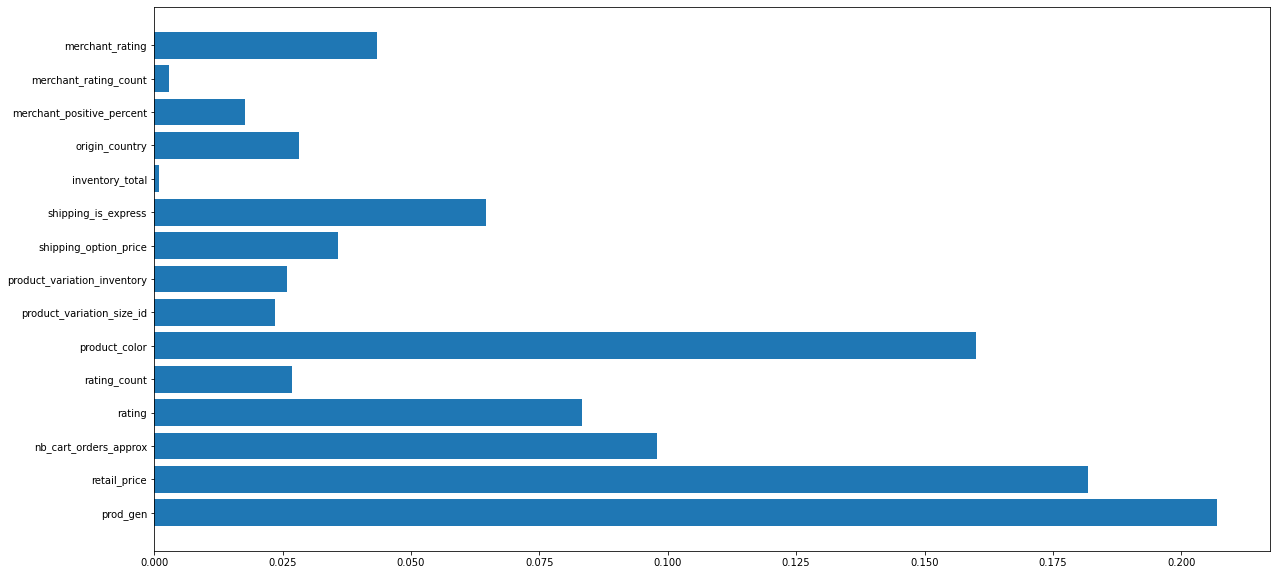

In [ ]:
plt.figure(figsize= (20,10))
plt.barh(X_train.columns, rfr_final_model.feature_importances_)

### LightGBM

In [53]:
#Randomized Search CV for LightGBM


lgbm_random_grid ={"n_estimators" : np.arange(200,400),
                  "max_depth" :  np.arange(30,60),
                  'learning_rate' : np.linspace(0.001,0.2,5)}

print(lgbm_random_grid)

{'n_estimators': array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
       291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,
       304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
       317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
       330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 

In [54]:
lgbm_randSearchCV = RandomizedSearchCV(estimator=lgb.LGBMRegressor(),
                                        param_distributions=lgbm_random_grid,
                                        scoring="neg_mean_squared_error",
                                        cv = kfold,
                                        n_jobs = -1, verbose = 2)

In [55]:
lgbm_randSearchCV.fit(X_train_transformed,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001  , 0.05075, 0.1005 , 0.15025, 0.2    ]),
                                        'max_depth': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
                                        'n_estimators': array([200, 201, 202, 203, 204, 205, 206, 207, 2...
       317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
       330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
       382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
       395, 396, 397, 398, 399]

In [56]:
print(lgbm_randSearchCV.best_estimator_)
print("="*80)
print(lgbm_randSearchCV.best_params_)
print("="*80)
print(np.sqrt(-lgbm_randSearchCV.best_score_))

LGBMRegressor(learning_rate=0.1005, max_depth=50, n_estimators=216)
{'n_estimators': 216, 'max_depth': 50, 'learning_rate': 0.1005}
6.333322910687383


In [59]:
# Grid Search CV for LightGBM
lgbm_param_grid = {"n_estimators" : np.arange(200,220),
                  "max_depth" :  np.arange(45,55),
                  'learning_rate' : np.linspace(0.01,0.2,5)}


lgbm_GSC = GridSearchCV(lgb.LGBMRegressor(),
                       param_grid = lgbm_param_grid,
                       scoring = "neg_mean_squared_error",
                       cv = kfold,
                       n_jobs=-1, verbose=2)

lgbm_GSC.fit(X_train_transformed,y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': array([0.01  , 0.0575, 0.105 , 0.1525, 0.2   ]),
                         'max_depth': array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
                         'n_estimators': array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219])},
             scoring='neg_mean_squared_error', verbose=2)

In [60]:
print(lgbm_GSC.best_estimator_)
print("="*80)
print(lgbm_GSC.best_params_)
print("="*80)
print(np.sqrt(-lgbm_GSC.best_score_))

LGBMRegressor(learning_rate=0.105, max_depth=45, n_estimators=210)
{'learning_rate': 0.105, 'max_depth': 45, 'n_estimators': 210}
6.314317791881365


In [62]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

In [64]:
# Predict on test data using final Random Forest Regression model
lgbm_final_model = lgbm_GSC.best_estimator_


lgbm_final_predictions = lgbm_final_model.predict(X_test_transformed)

lgbm_final_mse = MSE(y_test, lgbm_final_predictions)
lgbm_final_rmse = np.sqrt(lgbm_final_mse)   
lgbm_final_mae = MAE(y_test, lgbm_final_predictions)

print(f"The RMSE for Light GBM regression model is {lgbm_final_rmse:.2f}")
print(f"The MAE for Light GBM regression model is {lgbm_final_mae:.2f}")
lgbm_final_rmse

The RMSE for Light GBM regression model is 3.60
The MAE for Light GBM regression model is 1.53


3.597289926533181

<BarContainer object of 16 artists>

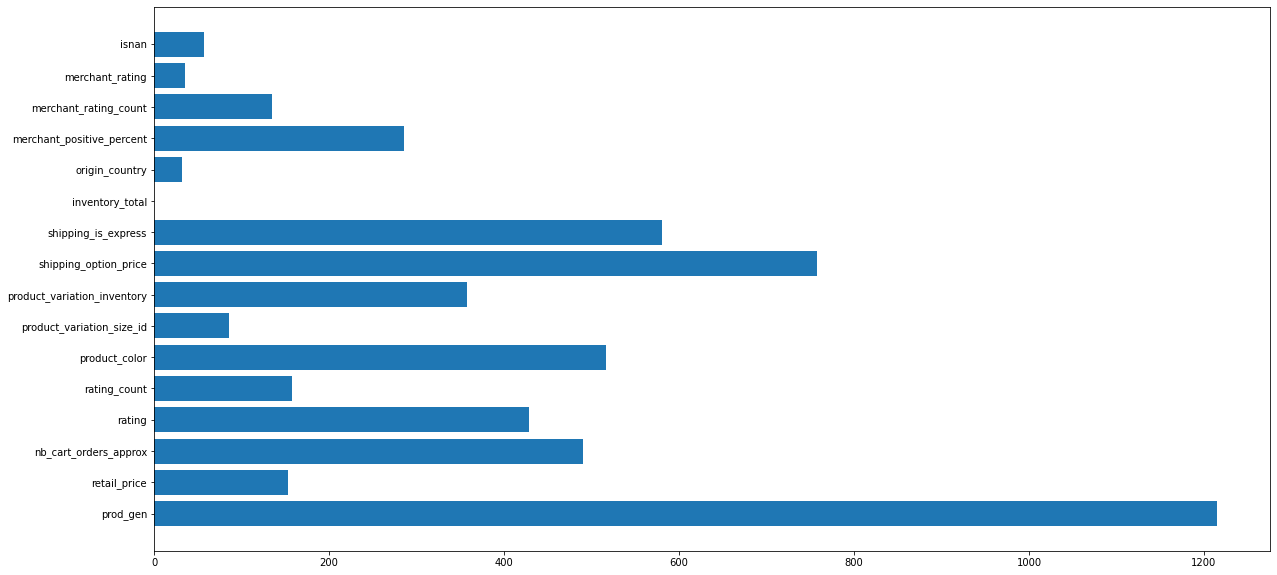

In [65]:
plt.figure(figsize= (20,10))
plt.barh(X_train.columns, lgbm_final_model.feature_importances_)

###**XGBoost Tuning**

In [ ]:
#Randomized Search CV for LightGBM

n_estimators = [int(x) for x in np.linspace(100, 400, 4)]

max_depth = [int(x) for x in np.linspace(3, 50, 5)] 

xgb_random_grid = {'n_estimators': n_estimators,
                    'max_depth' : max_depth,
                    'learning_rate' : np.linspace(0,0.5,5)}

print(xgb_random_grid)

{'n_estimators': [100, 200, 300, 400], 'max_depth': [3, 14, 26, 38, 50], 'learning_rate': array([0.   , 0.125, 0.25 , 0.375, 0.5  ])}


In [ ]:
xgb_randSearchCV = RandomizedSearchCV(estimator=XGBRegressor(),
                                        param_distributions=xgb_random_grid,
                                        scoring="neg_mean_squared_error",
                                        cv = kfold,
                                        n_iter=20,
                                        n_jobs = -1, verbose = 2)

In [ ]:
xgb_randSearchCV.fit(X_train_transformed,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[16:34:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBRegressor(), n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.   , 0.125, 0.25 , 0.375, 0.5  ]),
                                        'max_depth': [3, 14, 26, 38, 50],
                                        'n_estimators': [100, 200, 300, 400]},
                   scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print(xgb_randSearchCV.best_estimator_)
print("="*80)
print(xgb_randSearchCV.best_params_)
print("="*80)
print(np.sqrt(-xgb_randSearchCV.best_score_))

XGBRegressor(learning_rate=0.375, n_estimators=300)
{'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.375}
7.264212151577998


In [ ]:
# Grid Search CV for XGBoost
xgb_param_grid = {"n_estimators" : [300],
                  "max_depth" :  [3,5,7,9],
                  'learning_rate' : np.linspace(0.2,0.5,2)}


xgb_GSC = GridSearchCV(XGBRegressor(),
                       param_grid = xgb_param_grid,
                       scoring = "neg_mean_squared_error",
                       cv = kfold,
                       n_jobs=-1, verbose=2)

xgb_GSC.fit(X_train_transformed,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[16:35:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'learning_rate': array([0.2, 0.5]),
                         'max_depth': [3, 5, 7, 9], 'n_estimators': [300]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print(xgb_GSC.best_estimator_)
print("="*80)
print(xgb_GSC.best_params_)
print("="*80)
print(np.sqrt(-xgb_GSC.best_score_))

XGBRegressor(learning_rate=0.2, n_estimators=300)
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
7.264995606241105


In [ ]:
# Predict on test data using final XGBoost model
xgb_final_model = xgb_GSC.best_estimator_

xgb_final_predictions = xgb_final_model.predict(X_test_transformed)

xgb_final_mse = MSE(y_test, xgb_final_predictions)
xgb_final_rmse = np.sqrt(xgb_final_mse)   

rmse_final["XGBoost"] = xgb_final_rmse
xgb_final_rmse

5.136746744490001

In [ ]:
rmse_final

{'Gradient Boost Regressor': 3.9714006376591864,
 'LightGBM': 3.429438918657748,
 'Random Forest': 4.403428429080713,
 'XGBoost': 5.136746744490001}

### Model after tune

In [ ]:
rmse_df_tuned = pd.DataFrame.from_dict(rmse_final, orient='index').reset_index()
rmse_df_tuned.columns = ["Algorithm","RMSE_tuned"]
rmse_df_tuned = rmse_df_tuned.sort_values("RMSE_tuned").reset_index(drop=True)
rmse_df_tuned

,Algorithm,RMSE_tuned
0,LightGBM,3.429439
1,Gradient Boost Regressor,3.971401
2,Random Forest,4.403428
3,XGBoost,5.136747


In [ ]:
rmse_table = pd.merge(rmse_df, rmse_df_tuned, how="inner", on="Algorithm")
rmse_table

,Algorithm,RMSE,RMSE_tuned
0,XGBoost,6.555675,5.136747
1,Random Forest,5.480192,4.403428
2,LightGBM,4.858487,3.429439
3,Gradient Boost Regressor,4.434384,3.971401


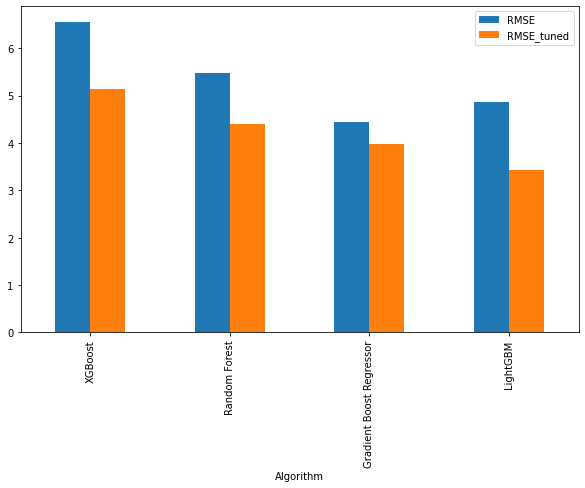

In [ ]:
rmse_table.sort_values("RMSE_tuned",ascending=False).plot(x="Algorithm",
                y=["RMSE","RMSE_tuned"],
                kind="bar",
                figsize=(10,6))

## Best model feature important

<BarContainer object of 15 artists>

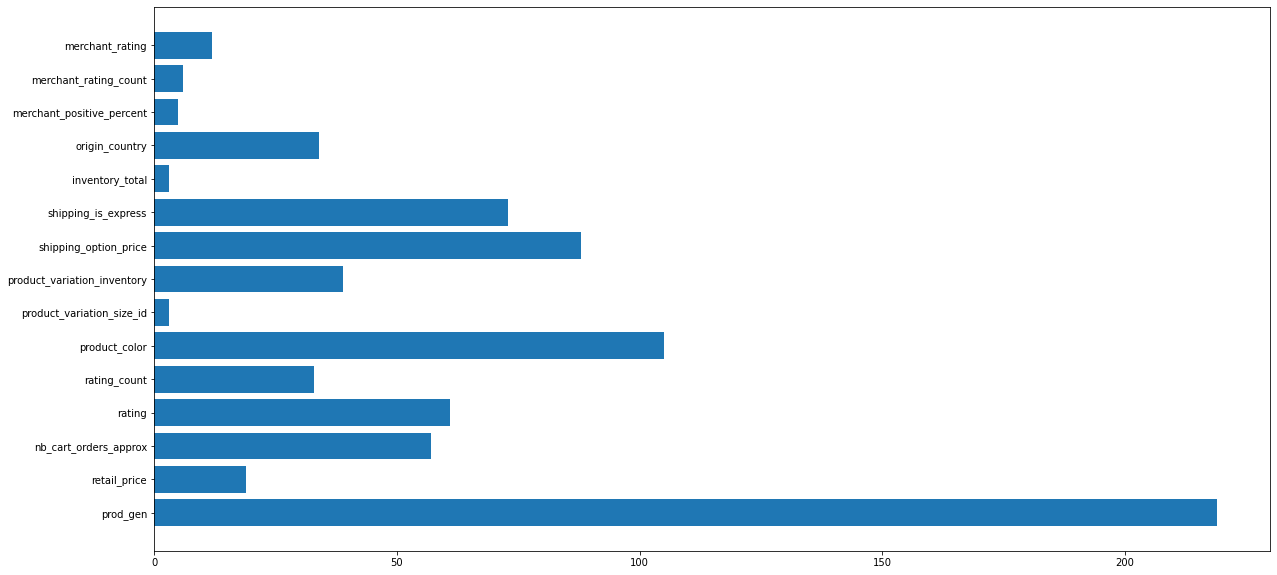

In [ ]:
plt.figure(figsize= (20,10))
plt.barh(X_train.columns, lgbm_final_model.feature_importances_)

In [ ]:
pd.DataFrame(data = lgbm_final_model.feature_importances_, index = X.columns,columns = ['coefficient']).sort_values(by = 'coefficient',ascending=False)

,coefficient
prod_gen,219
product_color,105
shipping_option_price,88
shipping_is_express,73
rating,61
nb_cart_orders_approx,57
product_variation_inventory,39
origin_country,34
rating_count,33
retail_price,19


In [ ]:
lgbm_final_mse = MSE(y_test, lgbm_final_predictions)
lgbm_final_rmse = np.sqrt(lgbm_final_mse) 
lgbm_final_mae = MAE(success_pred_forest,y_test)  

mae_final["LightGBM"] = lgbm_final_mae

print(f"The MAE for LightGBM model is {lgbm_final_mae:.2f}")

The MAE for LightGBM model is 2.78


In [ ]:
import joblib

joblib.dump(lgbm_final_model, "my_model.pkl")
# # and later...
# my_model_loaded = joblib.load("my_model.pkl")

['my_model.pkl']

In [ ]:
# Connect to Google Sheets
!pip install --upgrade oauth2client gspread

  Attempting uninstall: gspread
    Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1


In [ ]:
!pip install gspread_dataframe

In [ ]:
# Mount to Google Sheets 
from google.colab import auth
auth.authenticate_user()

# Import neccessary libraries
import gspread
from oauth2client.client import GoogleCredentials
from gspread_dataframe import set_with_dataframe

In [ ]:
# Authorize Google Sheets API
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
# ❗️ Note that before export data, you have to create the empty sheets in the Google Sheet first
def export_data(gsheet_key, worksheet_id, data):
    """gsheet_key (str): ID of Google Sheet File. (Key is the part behind /d/ and before /edit
                   For example: https://docs.google.com/spreadsheets/d/1WISuNUrWc-7BPO2s-pD3P3qqqgiLh0wRpvTNNtN21gA/edit?usp=sharing
                   Key is 1WISuNUrWc-7BPO2s-pD3P3qqqgiLh0wRpvTNNtN21gA
       worksheet_id (int): 0, 1, 2, ... 
       data (DataFrame): data to write
    """
    # Mở file theo gsheet key
    sh = gc.open_by_key('1nUURggx76E4y-rlRIJ1fXfUE81kHX9cqQvA9RPHmVyk')

    # Lựa chọn work sheet và load content của worksheet vào biến worksheet
    worksheet = sh.get_worksheet(worksheet_id)

    # Write to that worksheet
    # new_data = pd.concat(worksheet, analyse_data, axis=1)
    set_with_dataframe(worksheet, data)

In [ ]:
export_data('1nUURggx76E4y-rlRIJ1fXfUE81kHX9cqQvA9RPHmVyk',3, dt)

In [ ]:
LGBMRegressor(learning_rate=0.105, max_depth=45, n_estimators=210)

In [66]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', tfm),
    ('Machine_learning_model', lgb.LGBMRegressor(learning_rate=0.105, max_depth=45, n_estimators=210))
])

In [67]:
prepare_select_and_predict_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preparation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['retail_price',
                                                   'nb_cart_orders_approx',
                                                   'rating', 'rating_count',
                                                   'product_variation_inventory',
                                                   'shipping_option_price',
                                                   'inventory_total',
                                                   'merchant_positive_perce

In [68]:
some_data = X_test.iloc[:4]
some_labels = y_test.iloc[:4]

print("Predictions: ", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels: ", list(some_labels))

Predictions:  [13.47000333  9.81092295 10.21822866  9.97465638]
Labels:  [13.0, 10.0, 10.0, 11.0]


In [69]:
import joblib

joblib.dump(prepare_select_and_predict_pipeline, "my_model_lightGBM.pkl")
# # and later...
# my_model_loaded = joblib.load("my_model.pkl")

['my_model_lightGBM.pkl']